# Classfication

간단한 data 전처리 과정과 함께<br>
Data를 분류하는데 사용되는 machine learning 기법들을 알아보자.

## import

먼저 필요한 모듈들을 import한다.

In [59]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt    
from IPython.display import Image
%matplotlib inline

from plot_decision_regions import plot_decision_regions

sklearn의 버전을 체크하는 부분으로 제대로 install되었는지 확인한다.

In [3]:
from sklearn import __version__ as sklearn_version
from distutils.version import LooseVersion

if LooseVersion(sklearn_version) < LooseVersion('0.18'):
    raise ValueError('Please use scikit-learn 0.18 or newer')

In [4]:
sklearn_version

'0.18.1'

<br><br>

# Linear Discriminant Analysis

## wine dataset

In [14]:
import pandas as pd

df_wine = pd.read_csv('~/fintech/data/wine.data', header=None) #각자 알맞은 wine.data 파일 경로 입력

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0) #7:3으로 분할
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test) #training set의 parameter를 사용하여 test set의 데이터도 변환.

### 4. Compute the mean vectors of each class

In [15]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



### 5. Compute the within-class scatter matrix

In [16]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          # sum class scatter matrices

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


### Check whether the training set labels are uniformly distributed.

In [17]:
print('Class label distribution: %s' 
      % np.bincount(y_train)[1:]) # class의 분포가 동일하지 않은 것을 알 수 있다.

Class label distribution: [41 50 33]


### 6. Use the covariance matrix since classes are not equally distributed.(Scaled within-class scatter matrix)

In [18]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0],
                                                     S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


### 7. Compute the between-class scatter matrix

In [19]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13  # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    mean_overall = mean_overall.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


### 8. Solve the generalized eigenvalue problem

In [20]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.617808906
172.76152219
3.1648852322e-14
2.38789873511e-14
1.81713116791e-14
1.81713116791e-14
1.15224985384e-14
1.15224985384e-14
1.12931316303e-14
7.01590149973e-15
6.70805865805e-15
2.41250496214e-16
0.0


### 9. Plot the lincear discriminants

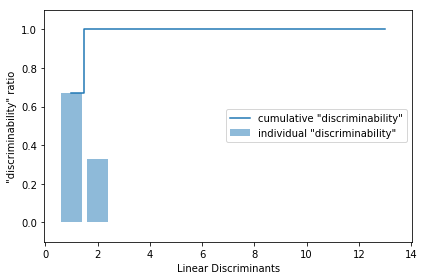

In [21]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [22]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


### 10. Transform the training dataset by multiplying the matrices

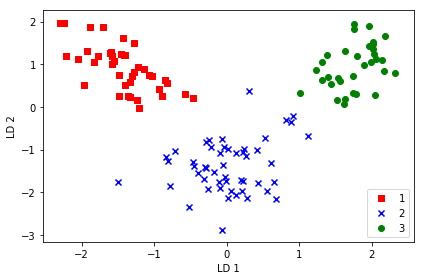

In [23]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## LDA via scikit-learn

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

In [27]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1 #x의 범위를 통해 plot의 범위 설정
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

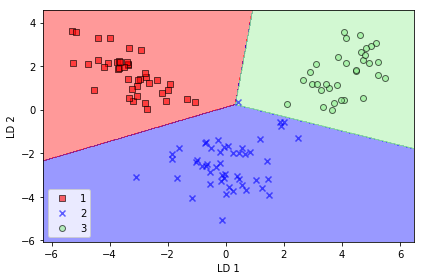

In [28]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

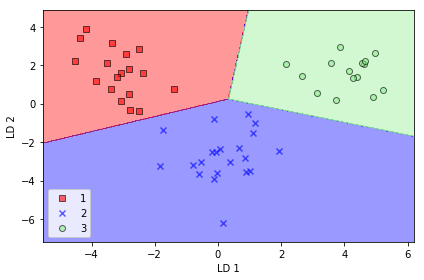

In [29]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

##  예제 데이터셋

scikit-learn에서 **Iris 데이터**를 가져온다.<br> 세번째와 네번째 열인 the petal length, the petal width를 feature로 사용하고<br> label에 해당하는 값은 **integer 값**으로 변환해 두었다. labels where 0=Iris-Setosa, 1=Iris-Versicolor, 2=Iris-Virginica

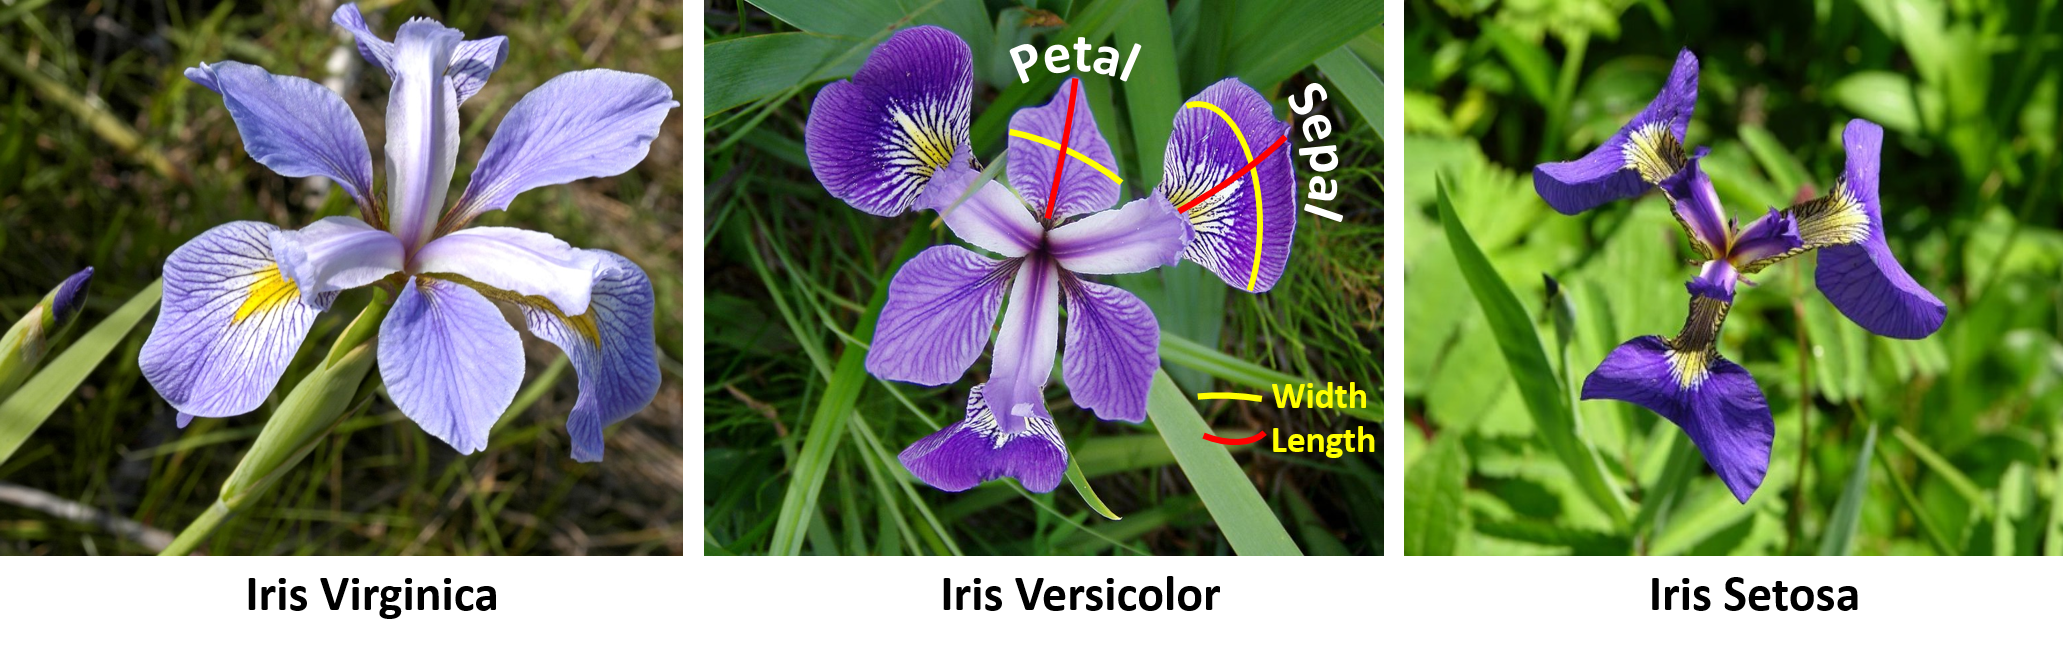

In [5]:
Image(filename='images/Iris_img.png', width=700) 

In [9]:
from sklearn import datasets

iris = datasets.load_iris()

data = iris.data
data.shape # iris.data: (150,4) 2d-array

X = iris.data[:, [2, 3]] # 2, 3번째 feature 만 사용
y = iris.target # iris.target: (150,) array  

print('Class labels:', np.unique(y))

print('Features names:', iris.feature_names)

Class labels: [0 1 2]
Features names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


<br>

데이터의 70%를 training에 사용하고 나머지 30%를 test data으로 사용하기 위해 **split**한다.<br>
이때 test_size는 test_set의 비율을 받고
**stratify=y**를 통해 traing과 test data의 **y비율이 같도록** 한다.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [11]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


<br>

X_train의 통계값을 이용하여 **정규화**시킴<br>

In [12]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print(np.mean(X_train_std), np.std(X_train_std))

1.86094526032e-16 1.0


## Perceptron

scikit-laern 버전에 맞추어 n_iter 또는 max_iter를 알맞게 사용해야 한다

In [10]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
        
ppn = Perceptron(n_iter=40, eta0=0.1, random_state=1) # eta0 : learning step size
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      n_iter=40, n_jobs=1, penalty=None, random_state=1, shuffle=True,
      verbose=0, warm_start=False)

In [11]:
y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())

Misclassified samples: 3


In [12]:
from sklearn.metrics import accuracy_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.93


In [13]:
print('Accuracy: %.2f' % ppn.score(X_test_std, y_test))

Accuracy: 0.93


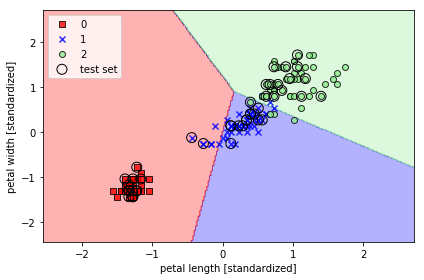

In [14]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('images/Perceptron.png', dpi=300)
plt.show()

<br>
<br>

## 로지스틱 회귀(Logistic regression)

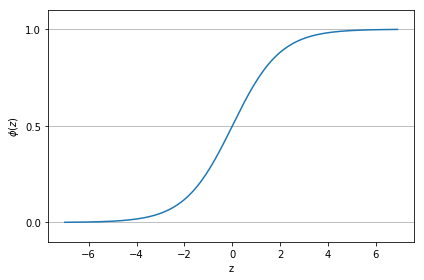

In [15]:
import matplotlib.pyplot as plt
import numpy as np


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
plt.savefig('images/sigmoid.png', dpi=300)
plt.show()

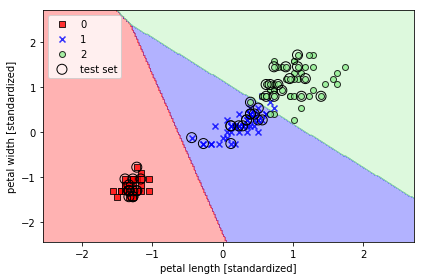

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('images/LR.png', dpi=300)
plt.show()

<br>

### Overfitting과 Regularization

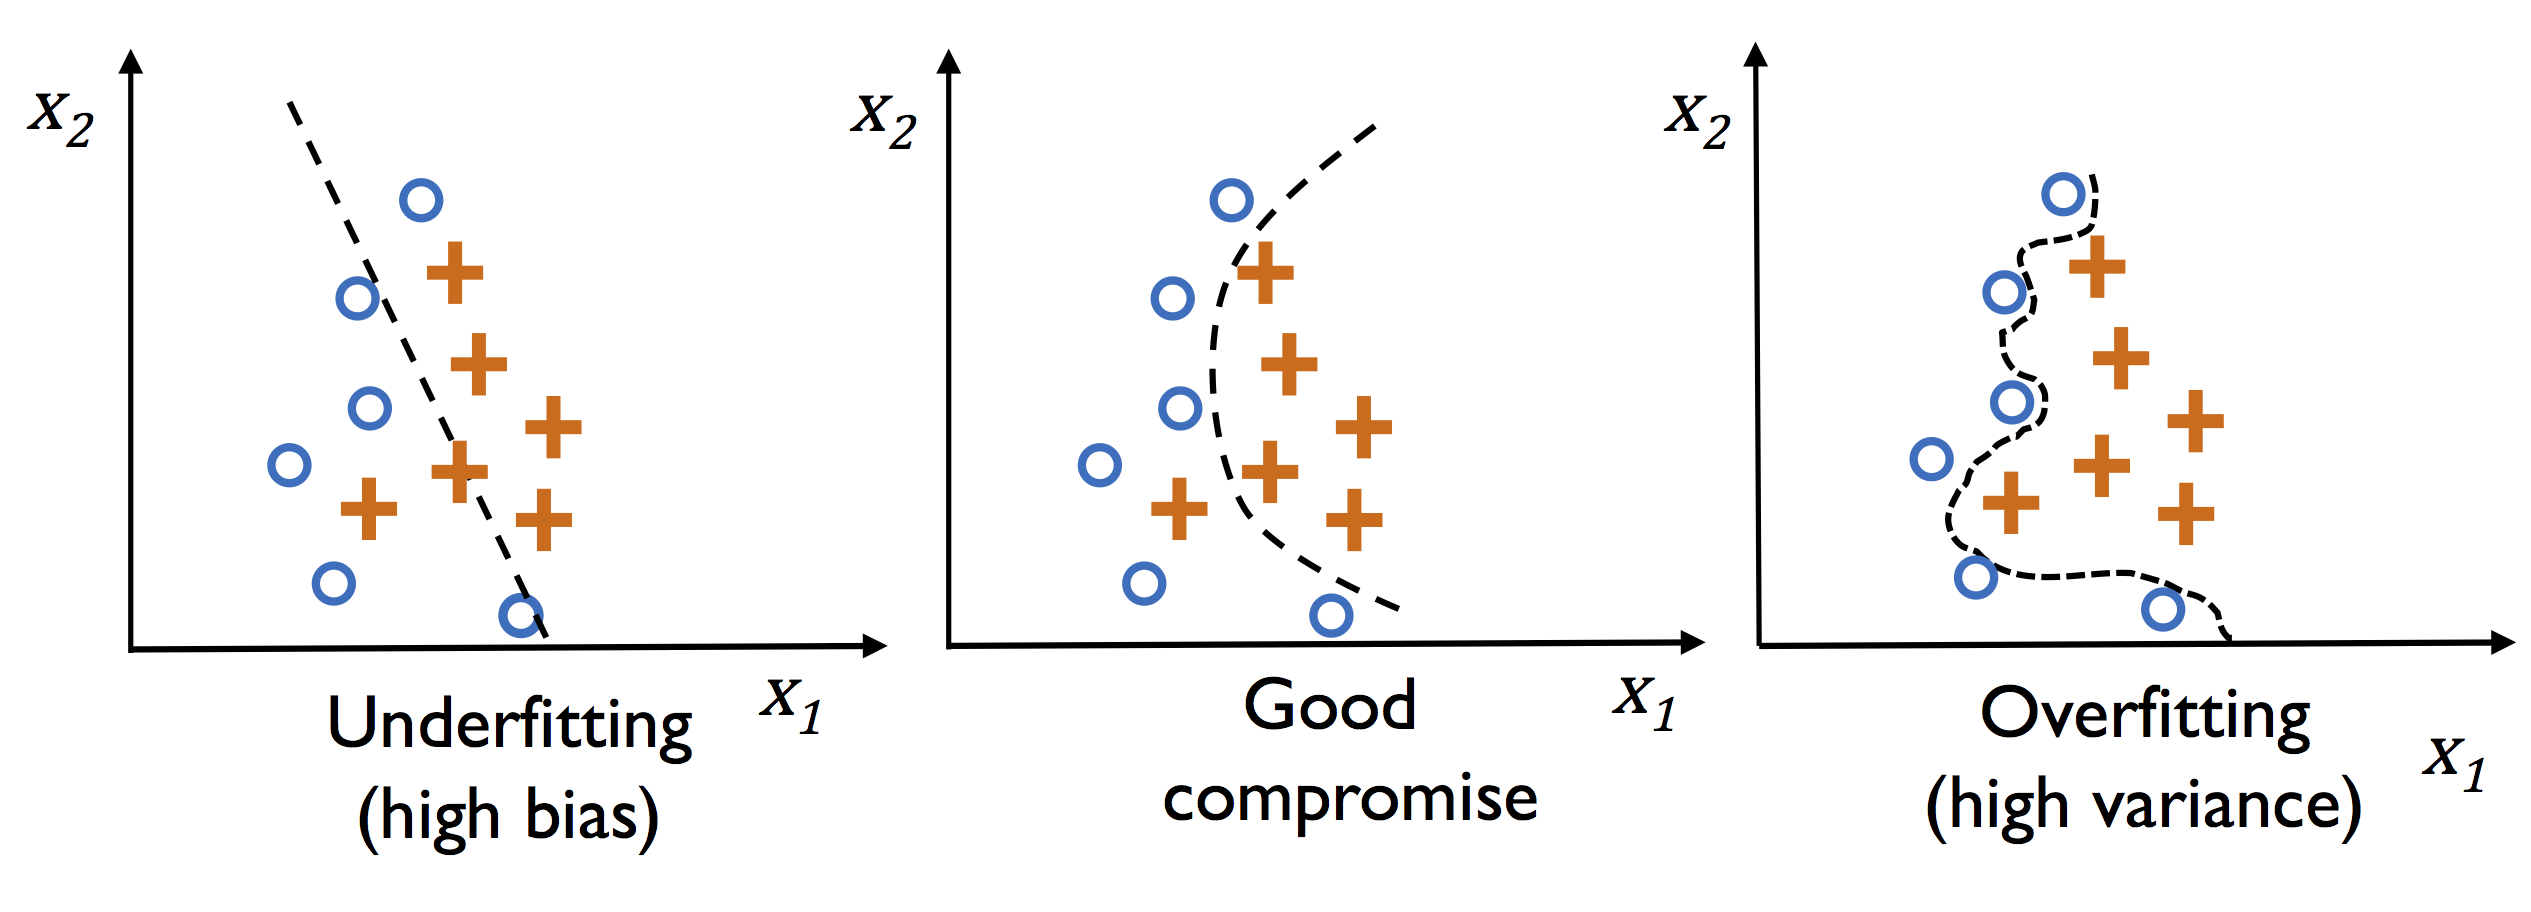

In [17]:
Image(filename='images/03_07.png', width=700) 

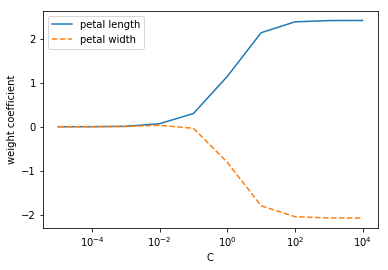

In [18]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.savefig('images/regularization.png', dpi=300)
plt.show()

<br>

## Support Vector Machines(SVM)

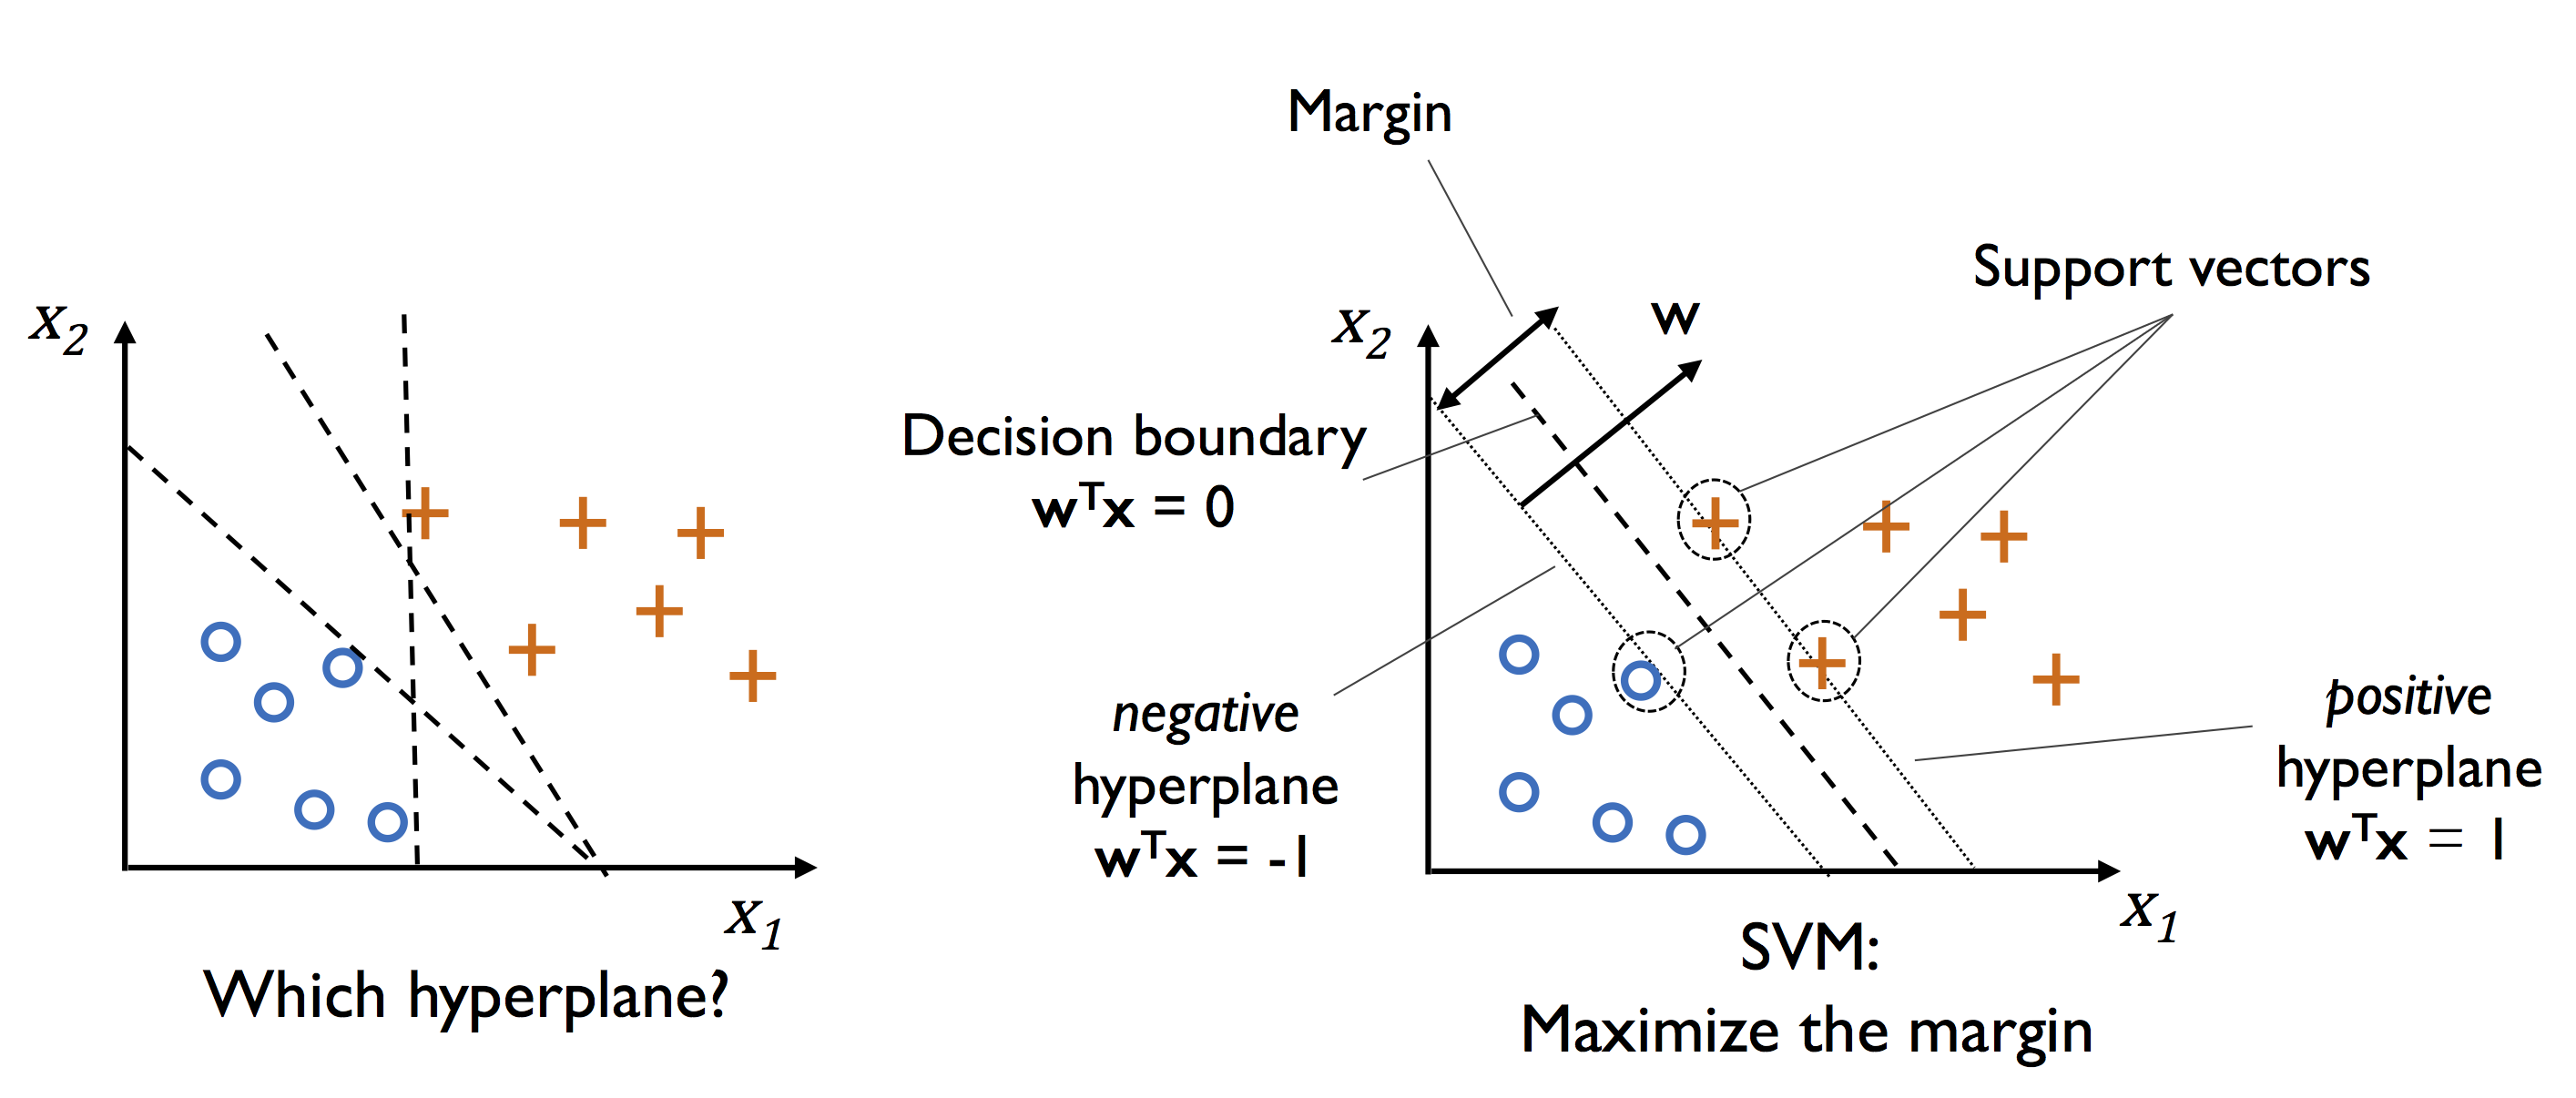

In [19]:
Image(filename='images/03_09.png', width=700) 

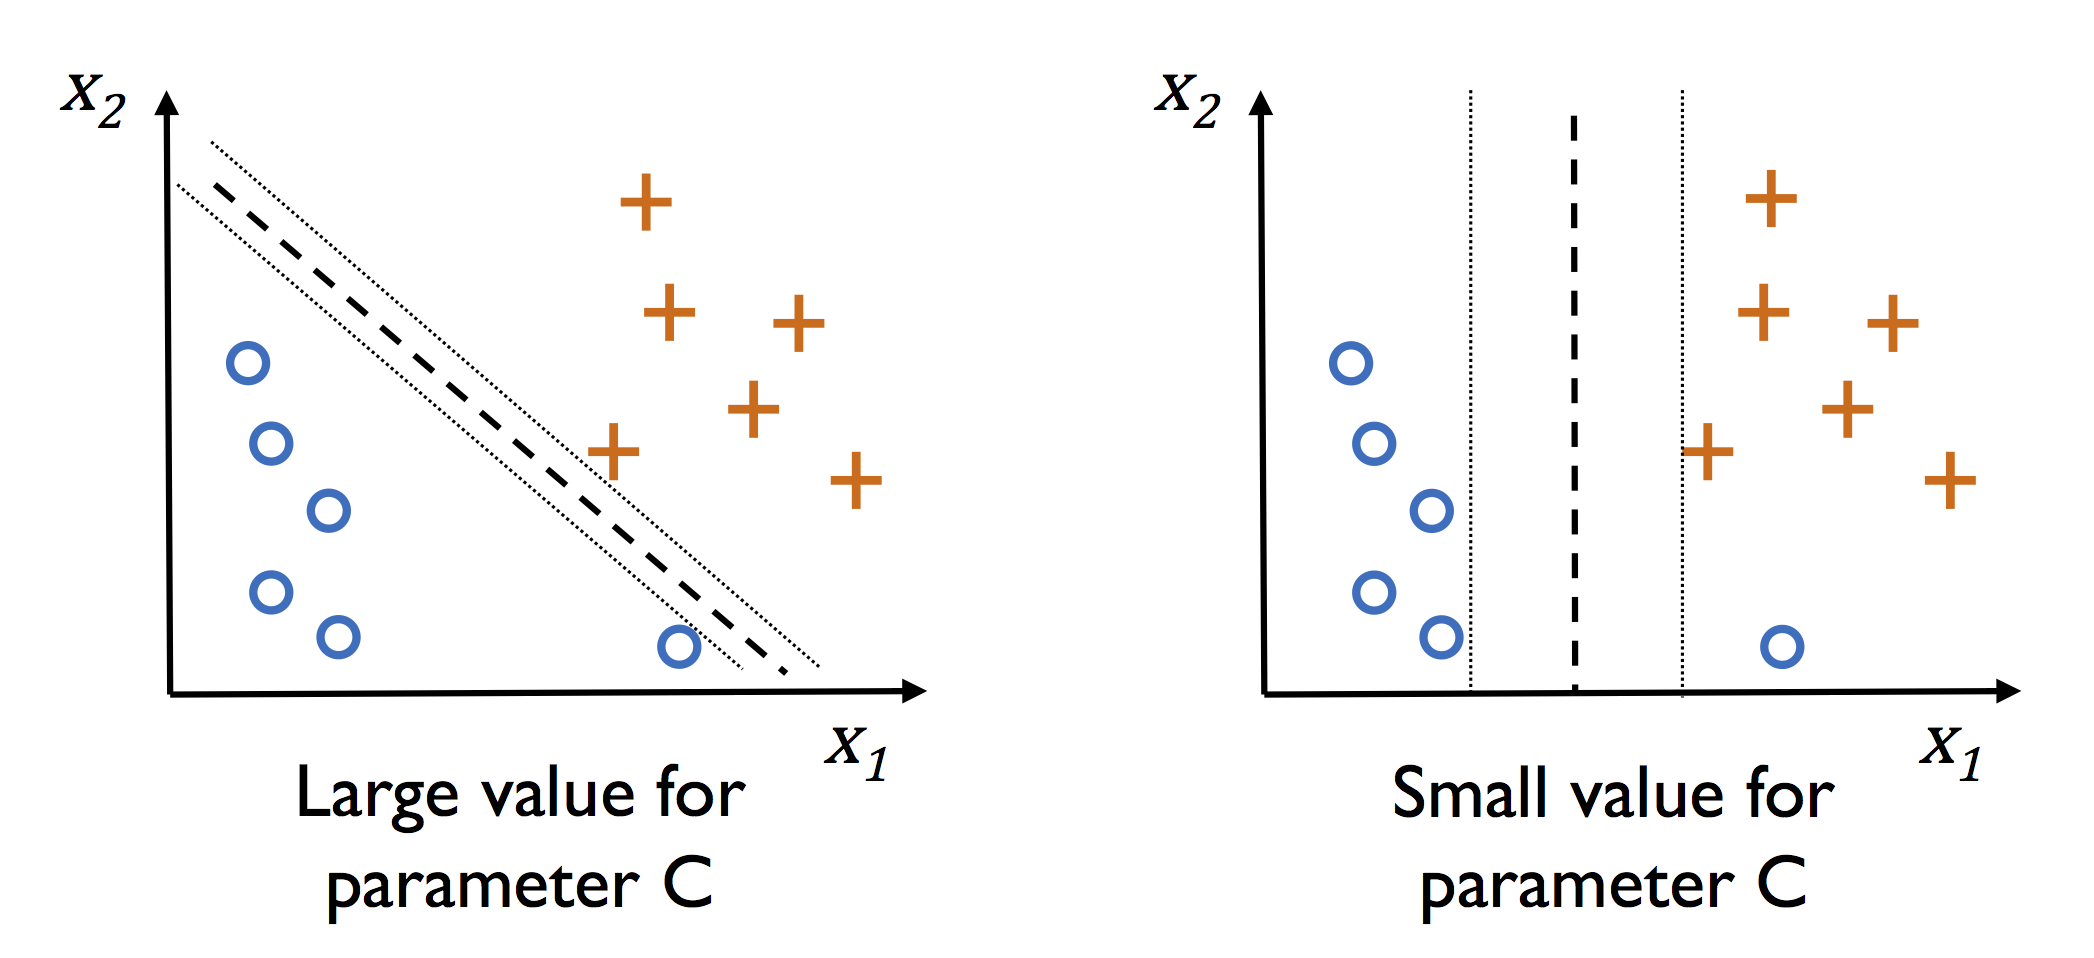

In [20]:
Image(filename='images/03_10.png', width=600) 

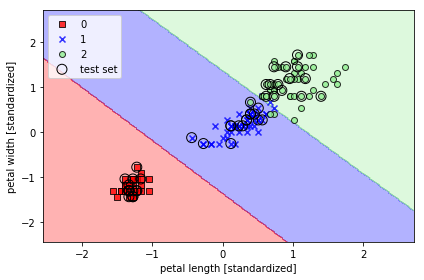

In [21]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)
 
plot_decision_regions(X_combined_std, 
                      y_combined,
                      classifier=svm, 
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('images/SVC.png', dpi=300)
plt.show()

<br>
<br>

## kernel SVM를 이용한 비선형 분류

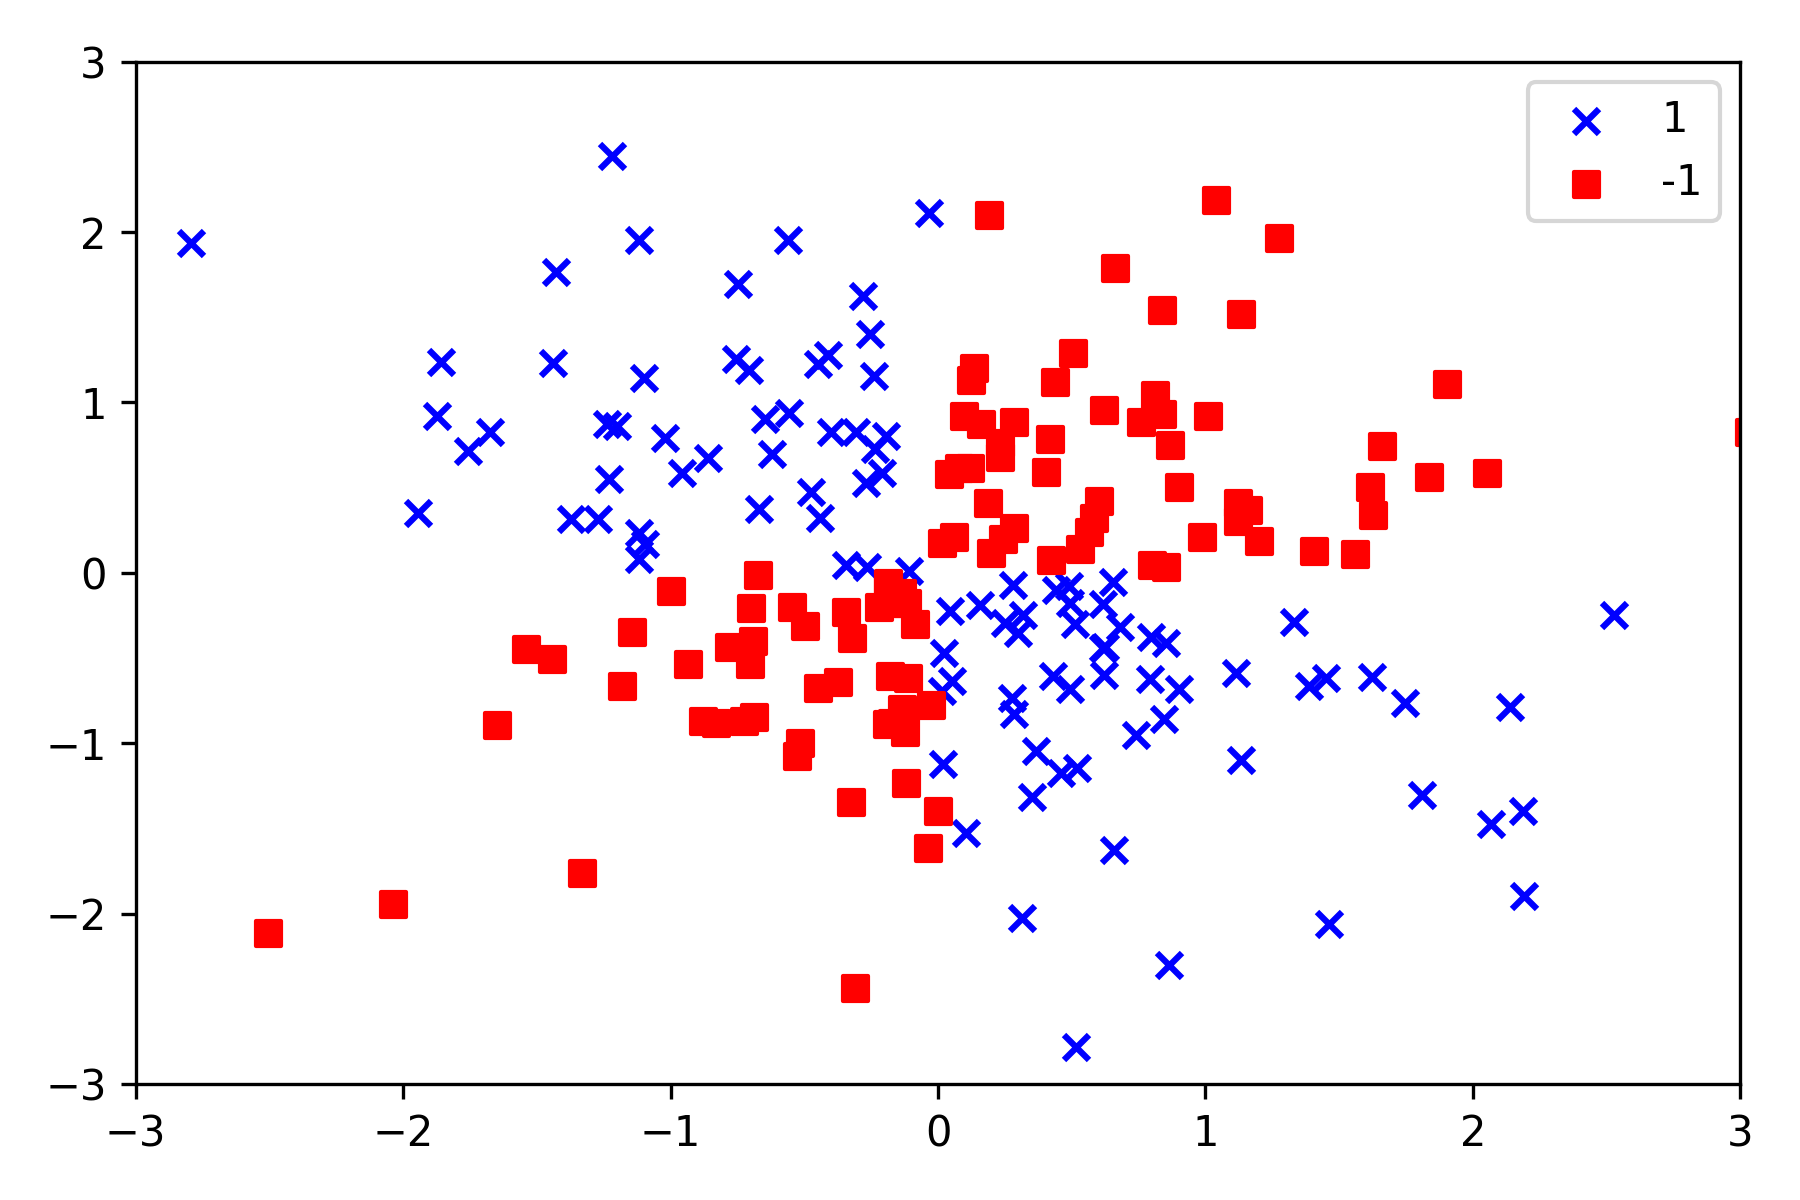

In [22]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)


Image(filename='images/xor.png', width=700) 

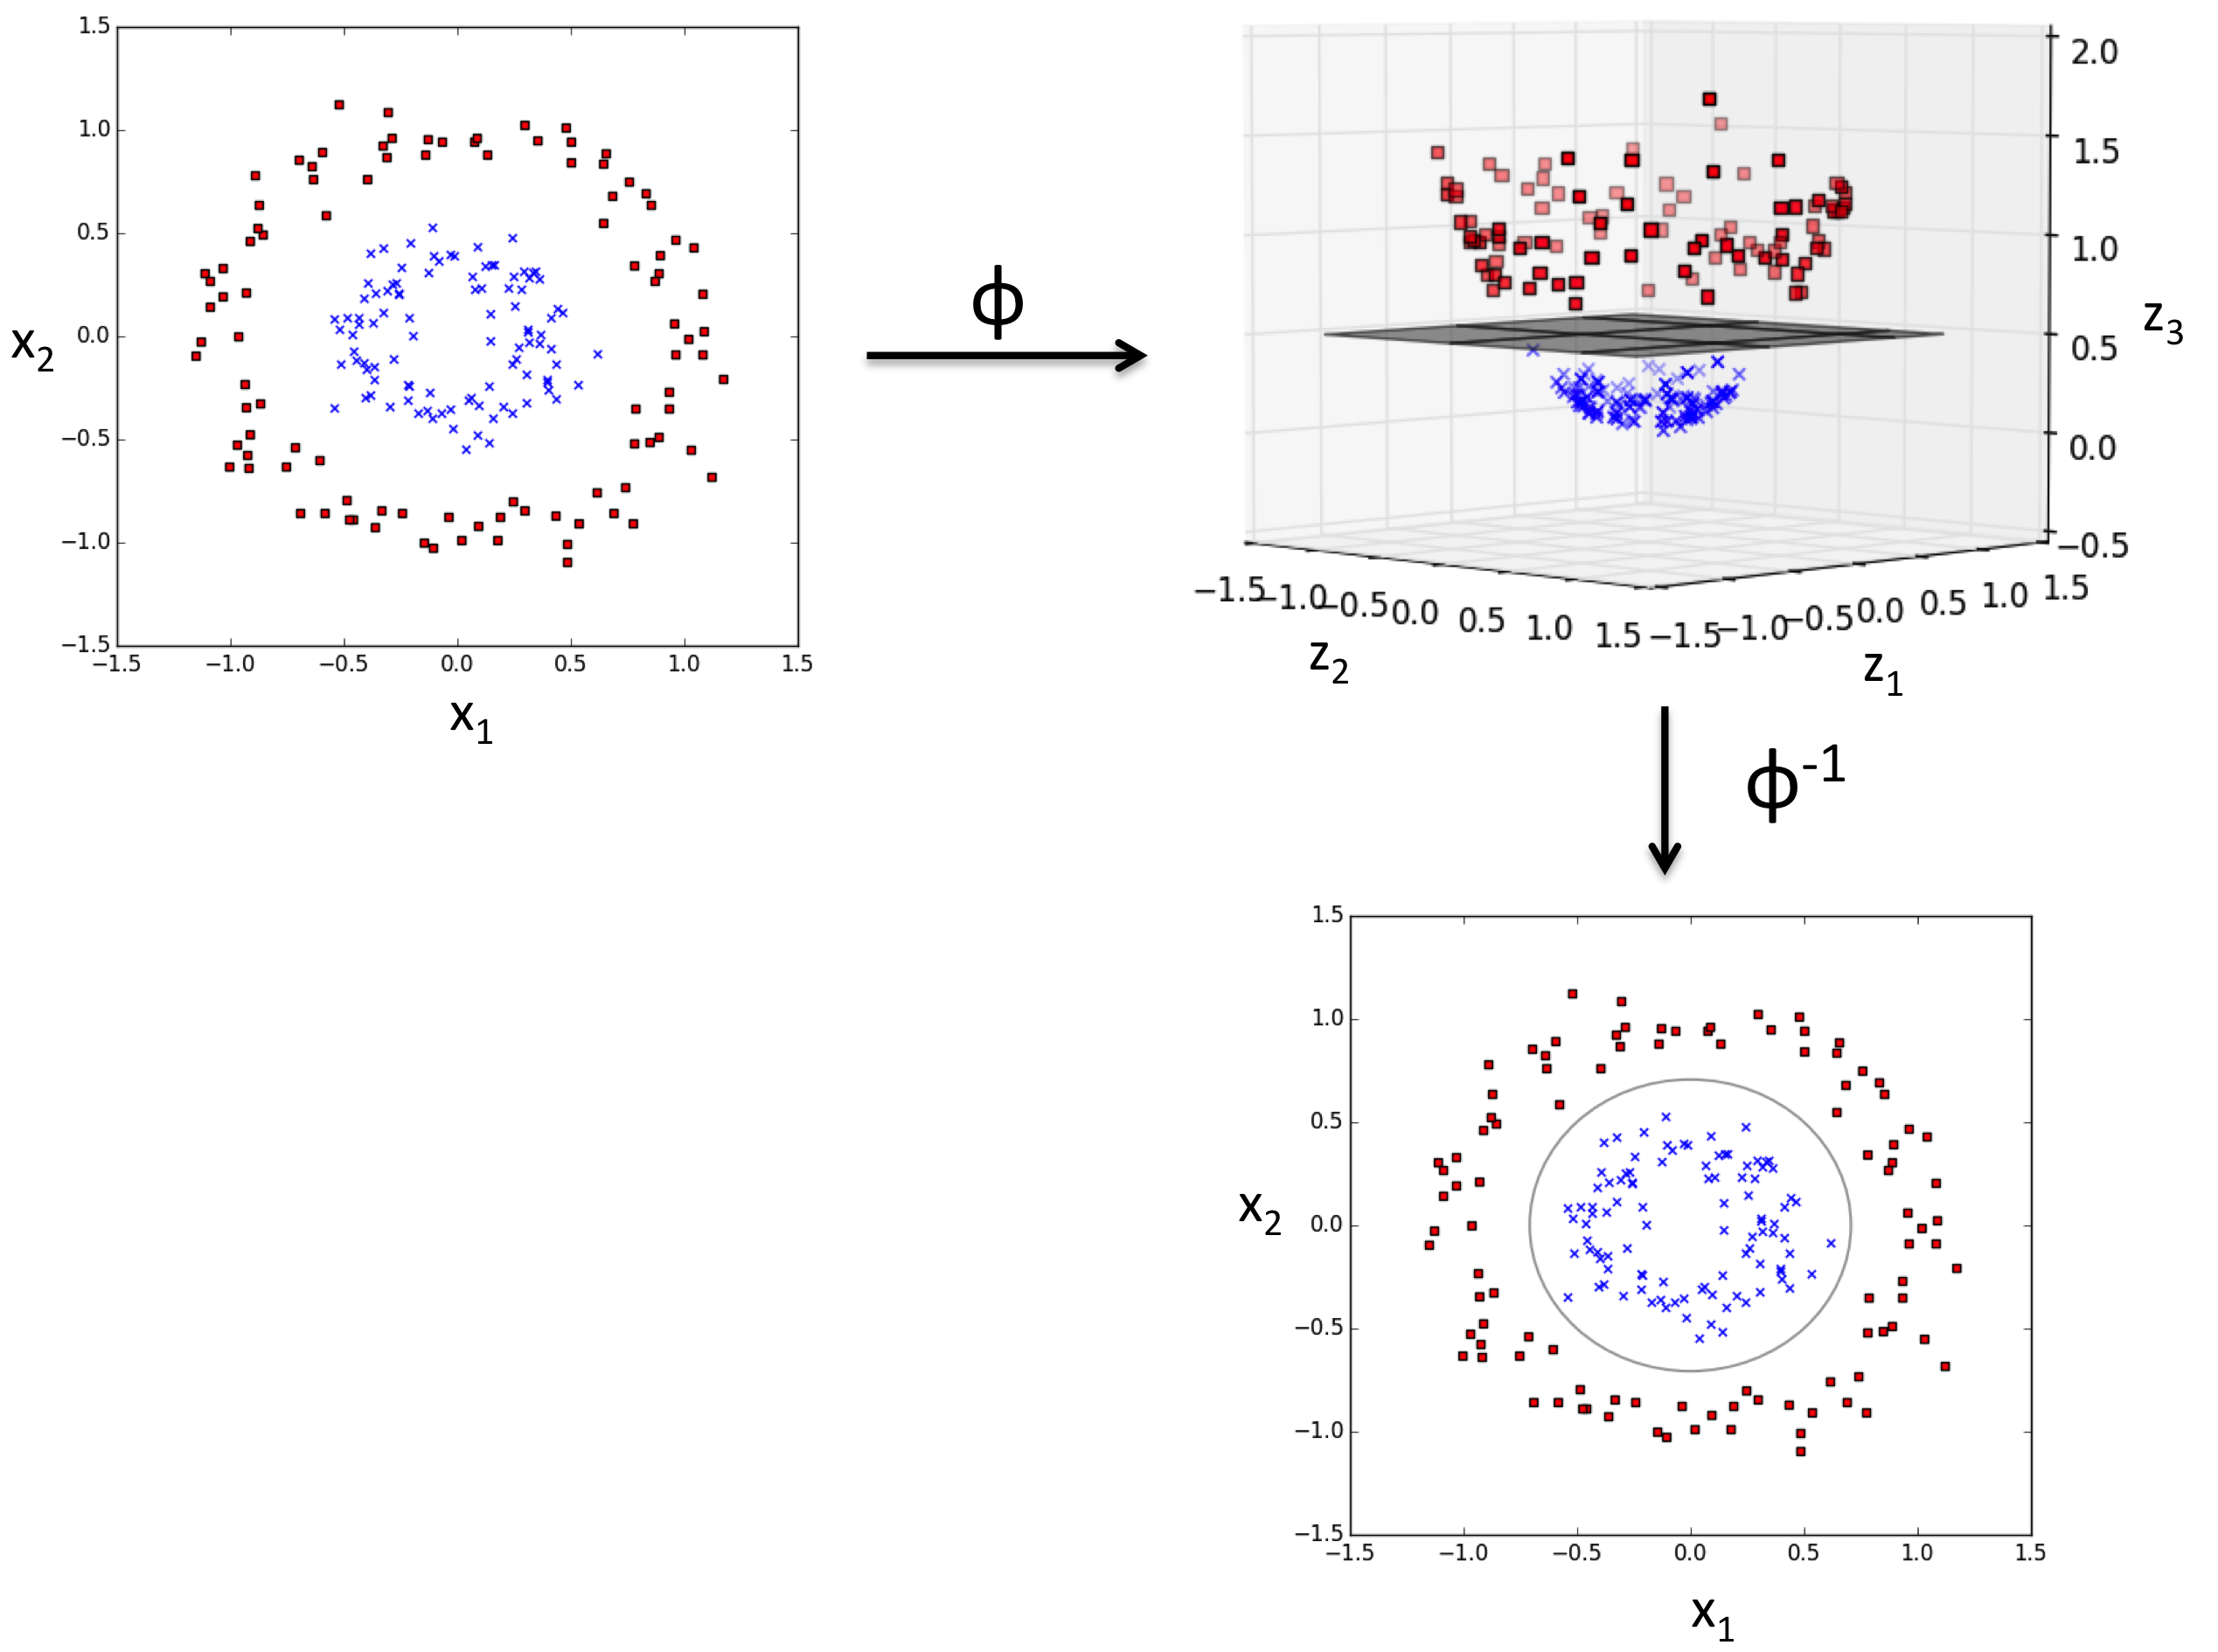

In [23]:
Image(filename='images/03_13.png', width=700) 

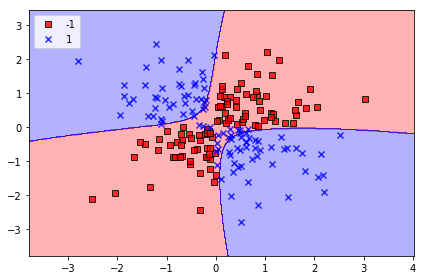

In [24]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('images/xor_classified.png', dpi=300)
plt.show()

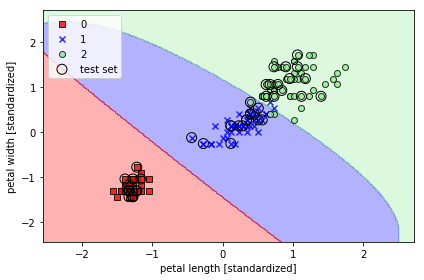

In [25]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('images/rbf.png', dpi=300)
plt.show()

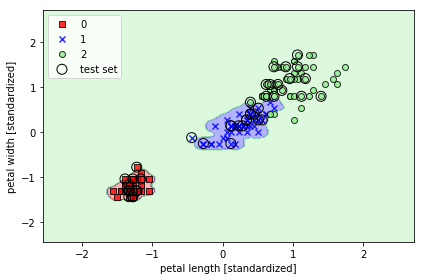

In [26]:
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('images/gamma.png', dpi=300)
plt.show()

<br>

## Multiclass classifier

In [27]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0))
ovo_clf.fit(X_train_std, y_train)
ovo_clf.predict(X_test_std)

array([2, 0, 0, 1, 1, 1, 2, 1, 2, 0, 0, 2, 0, 1, 0, 1, 2, 1, 1, 2, 2, 0, 1,
       2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 0, 1, 2, 2, 1, 0, 0])

In [28]:
ovo_clf1 = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0, decision_function_shape='ovo')
ovo_clf1.fit(X_train_std, y_train)
ovo_clf1.predict(X_test_std)

array([2, 0, 0, 1, 1, 1, 2, 1, 2, 0, 0, 2, 0, 1, 0, 1, 2, 1, 1, 2, 2, 0, 1,
       2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 0, 1, 2, 2, 1, 0, 0])

In [29]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(LogisticRegression(C=100.0, random_state=1))
ovr_clf.fit(X_train_std, y_train)
ovr_clf.predict(X_test_std)

array([2, 0, 0, 1, 1, 1, 2, 1, 2, 0, 0, 2, 0, 1, 0, 1, 2, 1, 1, 2, 2, 0, 1,
       2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 0, 1, 2, 2, 1, 0, 0])

In [30]:
ovr_clf1 = LogisticRegression(C=100.0, random_state=1, multi_class='ovr') # defualt
ovr_clf1.fit(X_train_std, y_train)
ovr_clf1.predict(X_test_std)

array([2, 0, 0, 1, 1, 1, 2, 1, 2, 0, 0, 2, 0, 1, 0, 1, 2, 1, 1, 2, 2, 0, 1,
       2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 0, 1, 2, 2, 1, 0, 0])

<br>
<br>

# 의사결정 나무

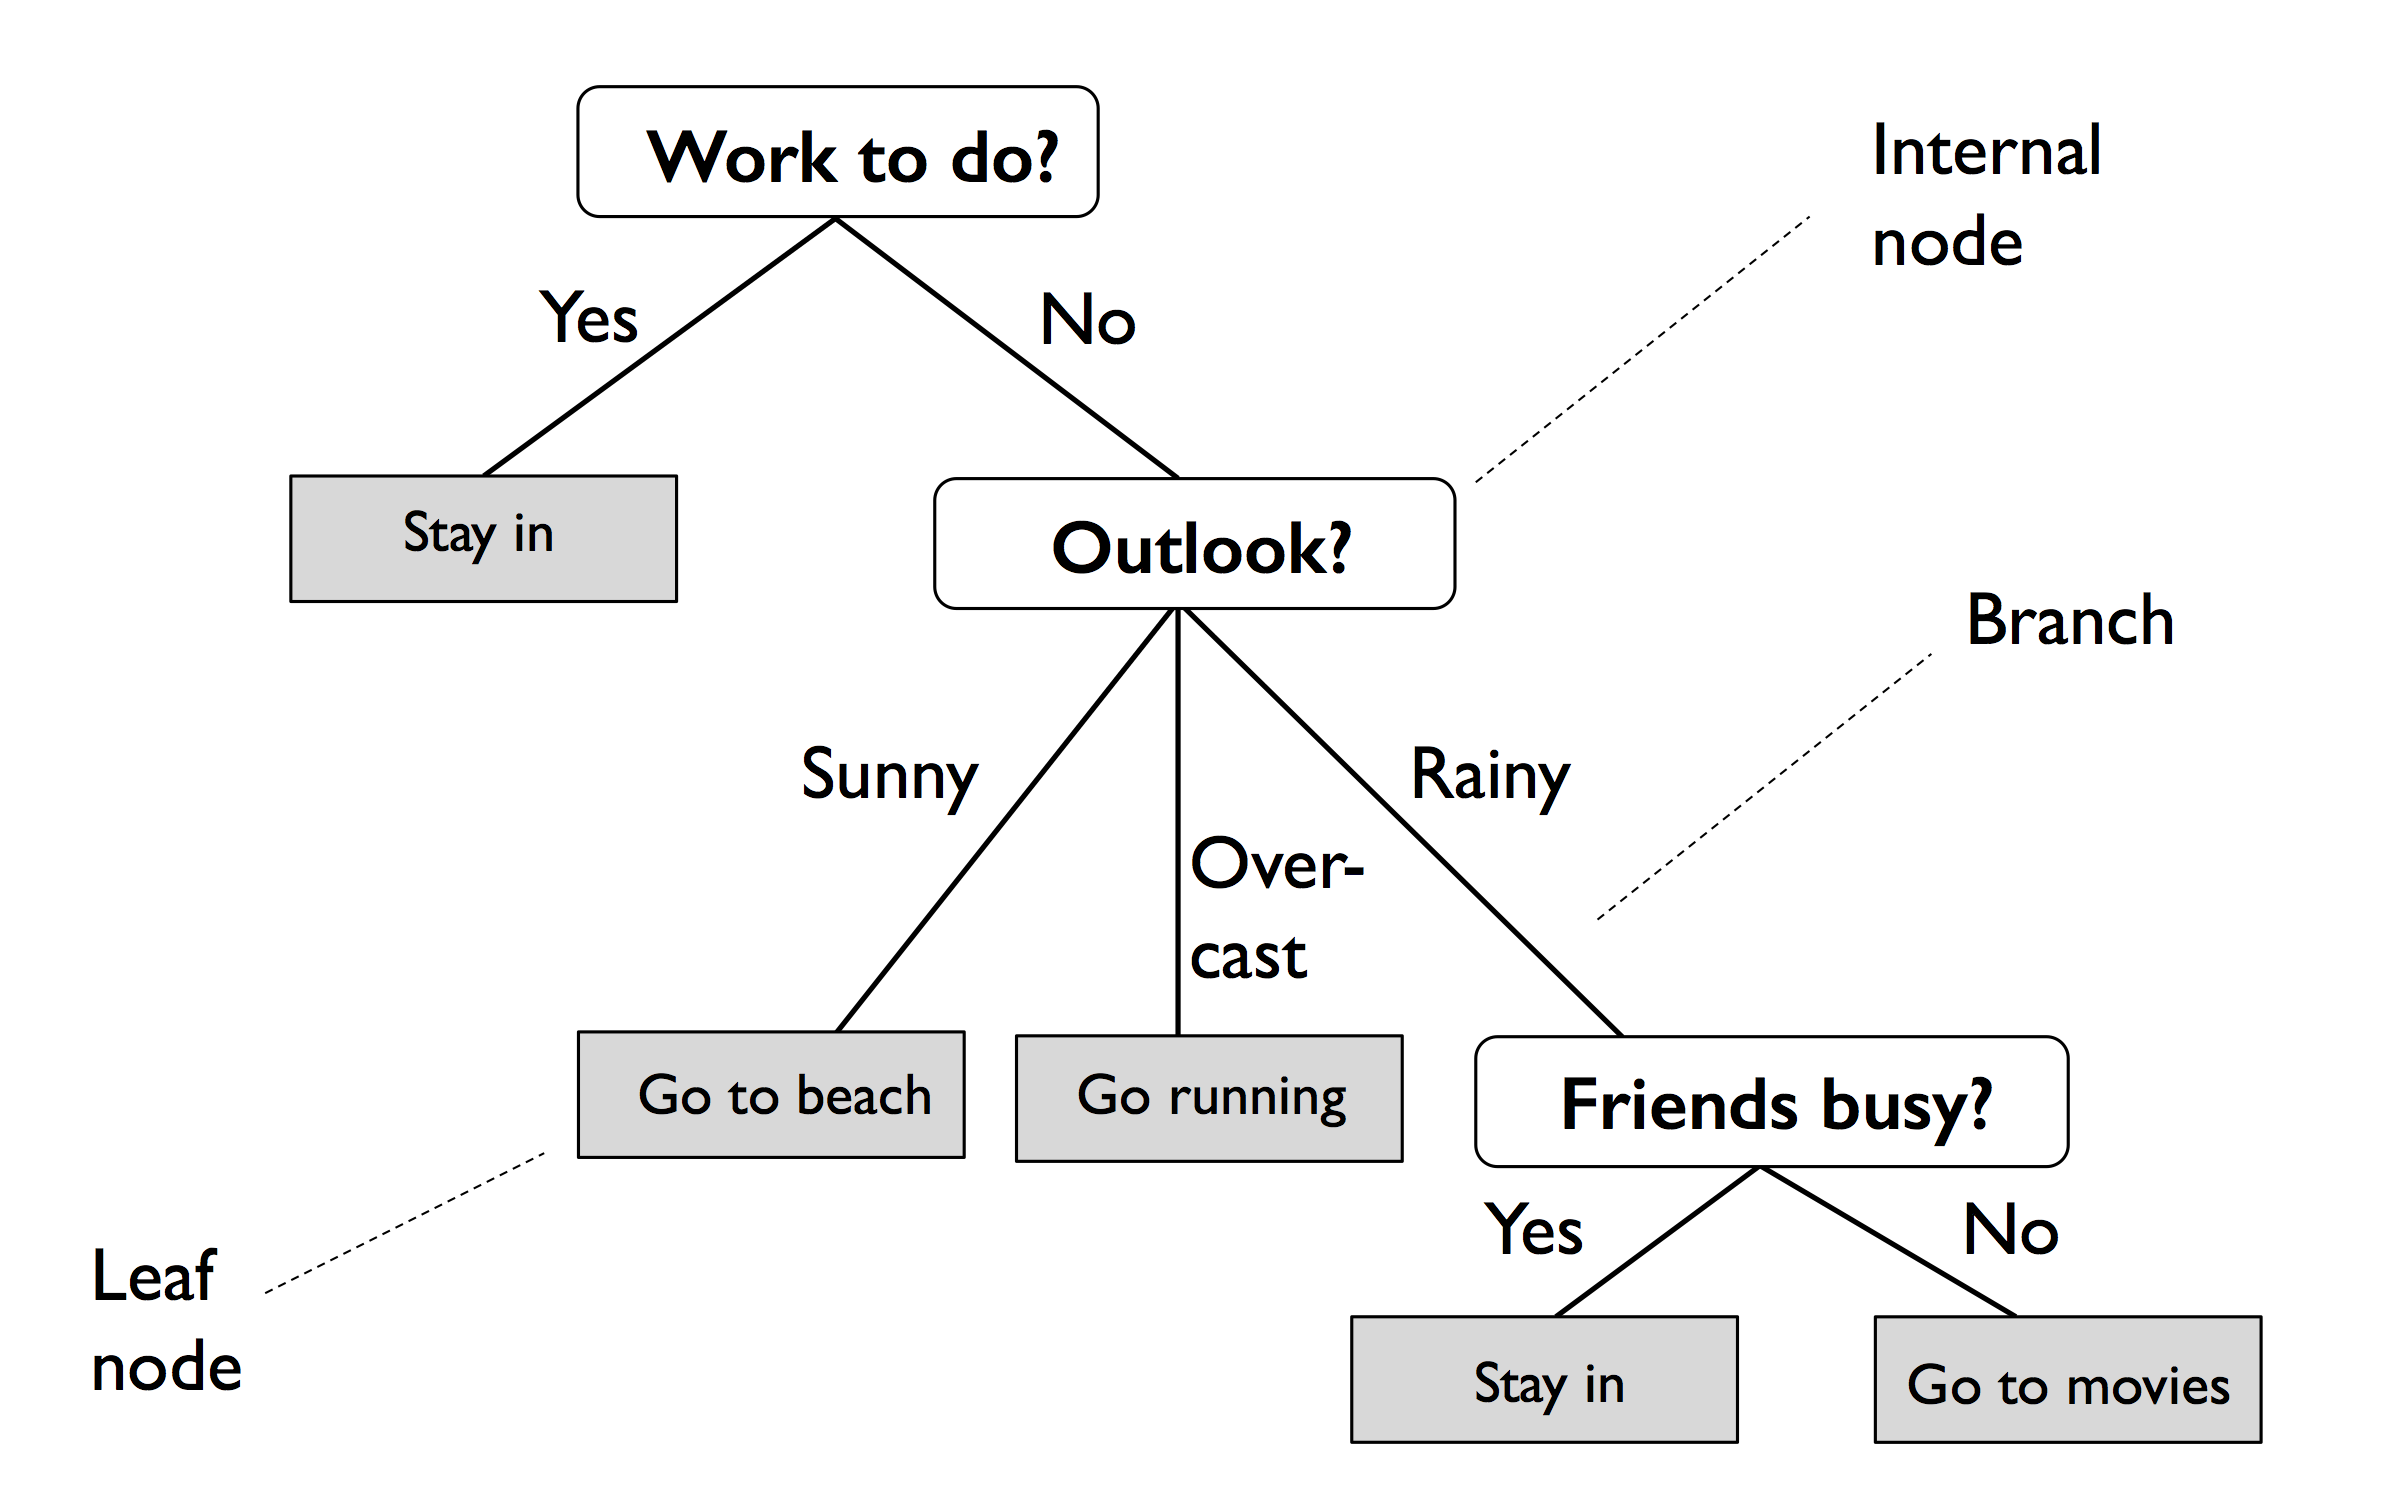

In [31]:
Image(filename='images/03_17.png', width=500) 

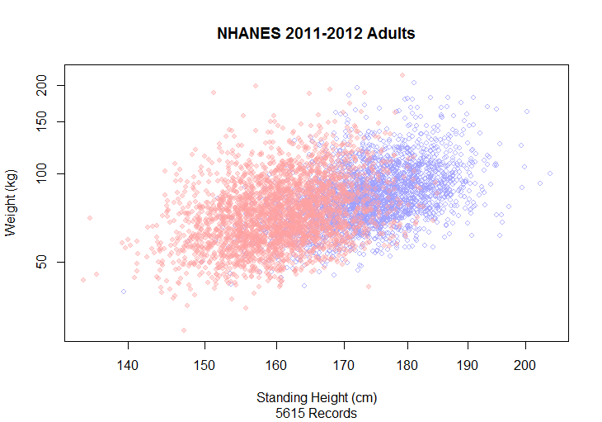

In [32]:
Image(filename='images/adults.png', width=500) 

### impurity

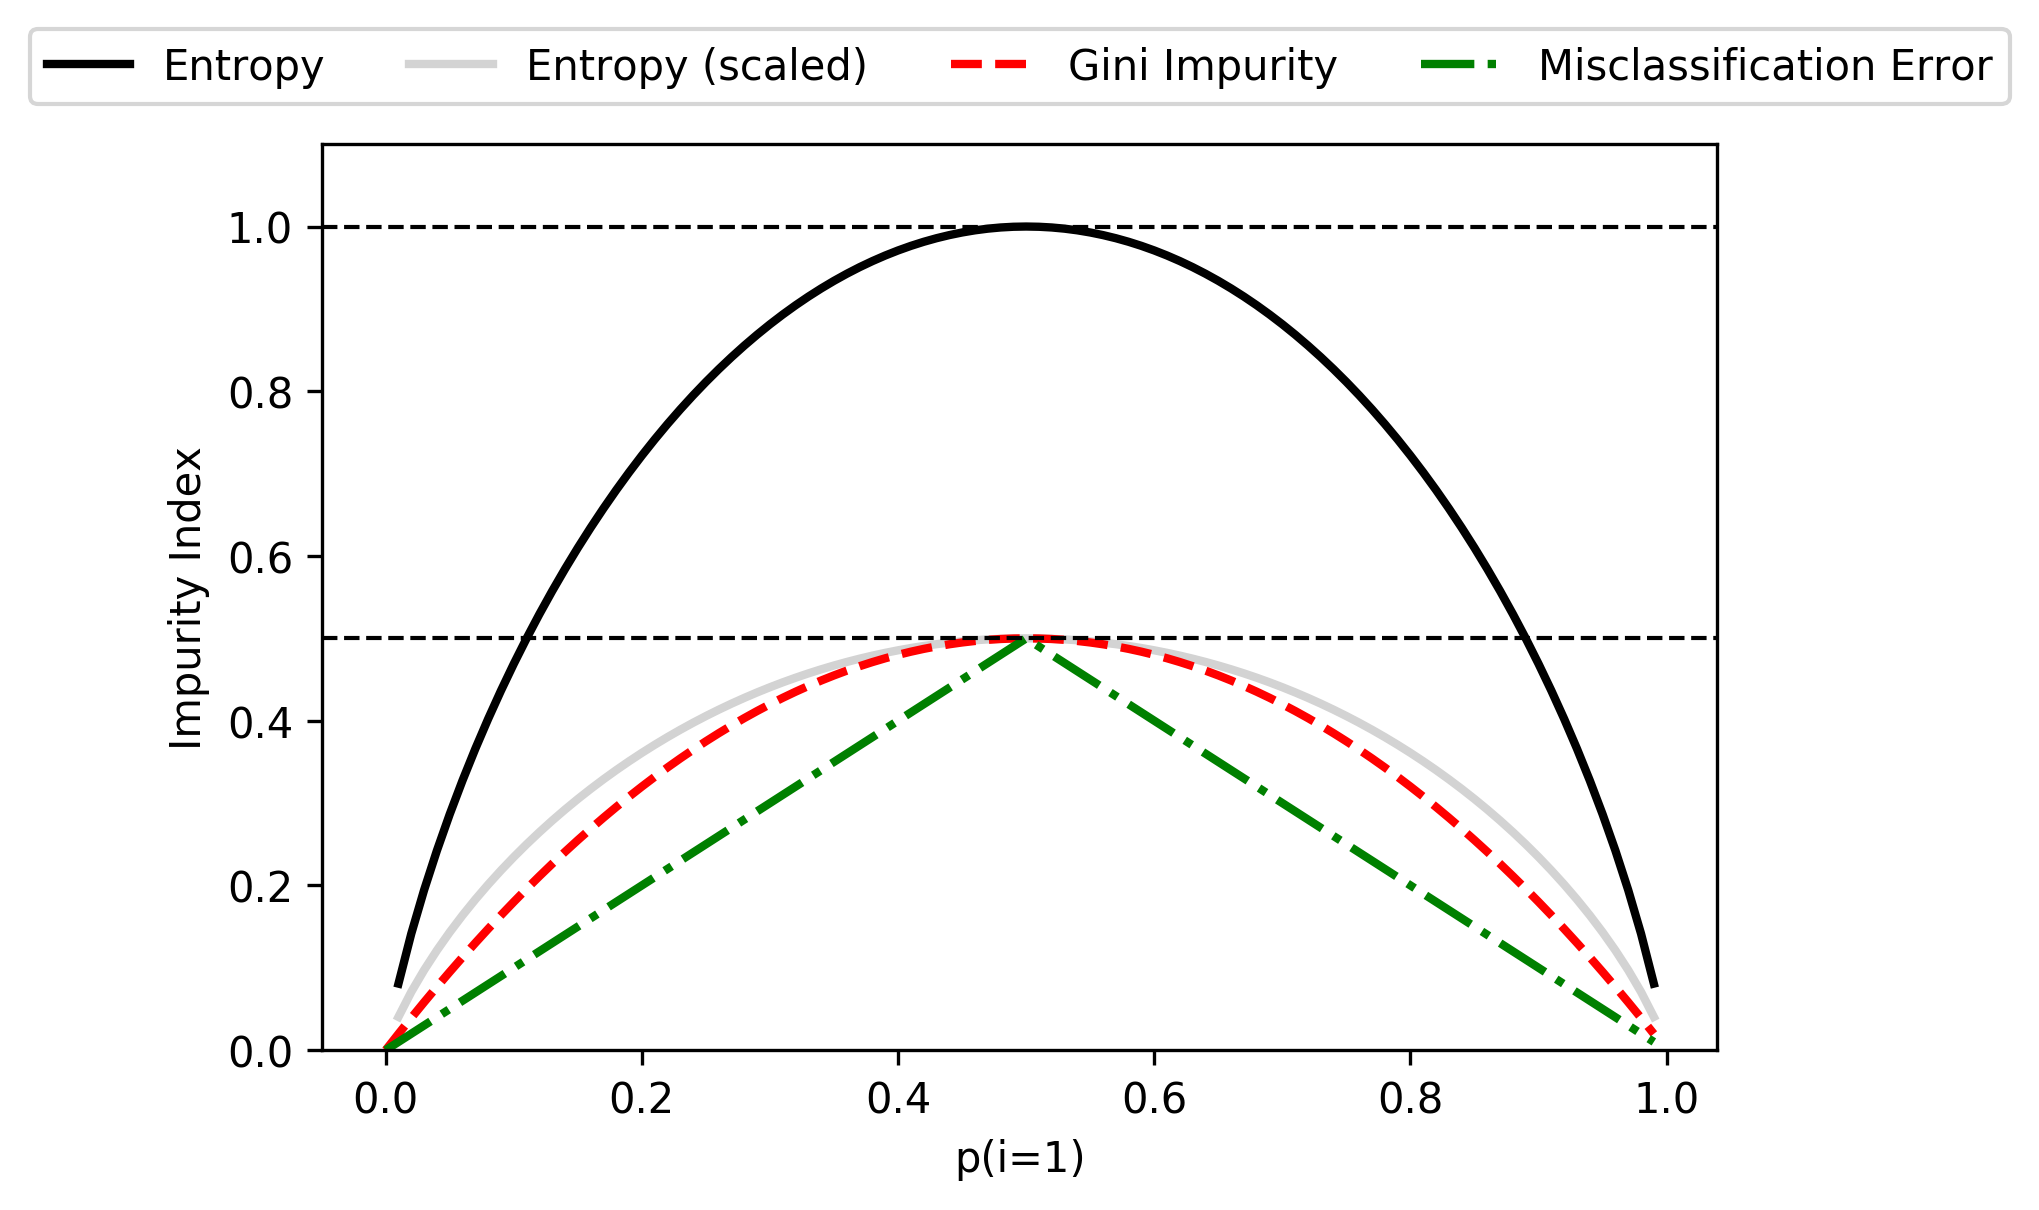

In [33]:
Image(filename='images/Impurity.png', width=500) 

### 의사결정나무

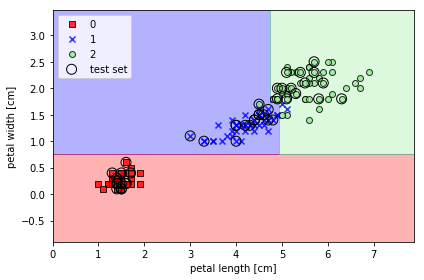

In [34]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=4, 
                              random_state=1)
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('images/DT.png', dpi=300)
plt.show()

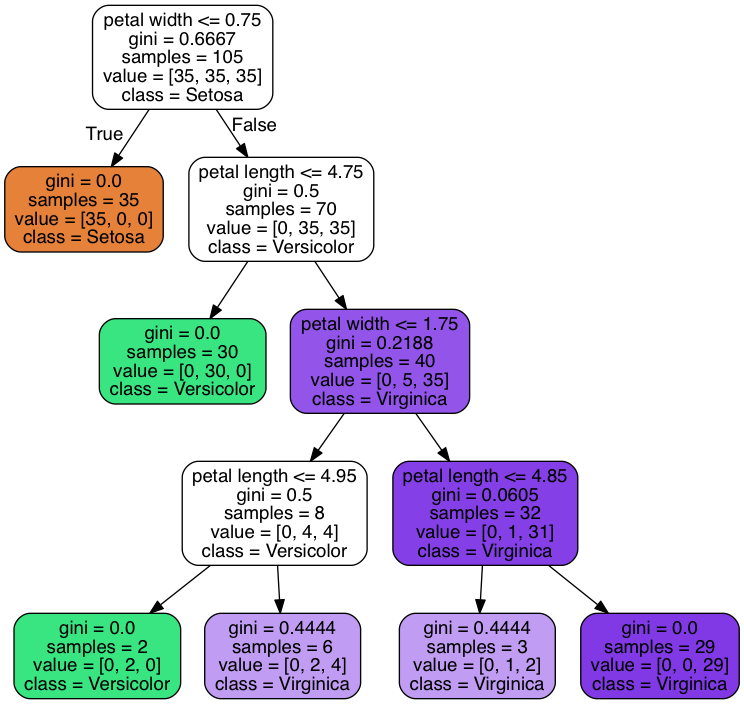

In [35]:
Image(filename='images/03_21.png', width=600) 

<br>
<br>

## Random Forests

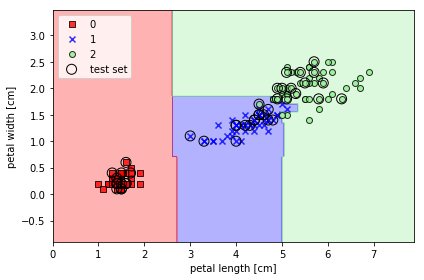

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('images/RF.png', dpi=300)
plt.show()

### Wine Dataset: Selecting Variables

In [3]:
import pandas as pd
import numpy as np
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

Class labels [1 2 3]


Index(['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
       'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color intensity', 'Hue',
       'OD280/OD315 of diluted wines', 'Proline'],
      dtype='object')
 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


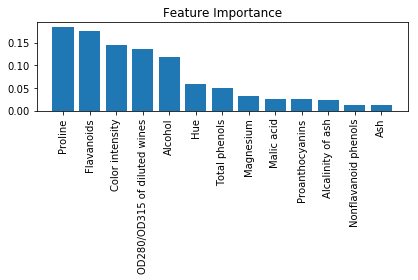

In [5]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

feat_labels = df_wine.columns[1:]
print(feat_labels) ## 입력 변수들

forest = RandomForestClassifier(n_estimators=500, ## tree 수
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_   # feature 중요성 값

indices = np.argsort(importances)[::-1]   # 역순(큰 순서로)

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))   # 출력 양식

plt.title('Feature Importance')
# bar 모양 그래프 plot
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')
# feature 이름 삽입
plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [6]:
from sklearn.feature_selection import SelectFromModel
# 학습된 모델로 부터 0.1 이상인 변수들을 선택함
sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of samples that meet this criterion:', 
      X_selected.shape[0])
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

Number of samples that meet this criterion: 124
 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529


## KNN(K-nearest neighbors)

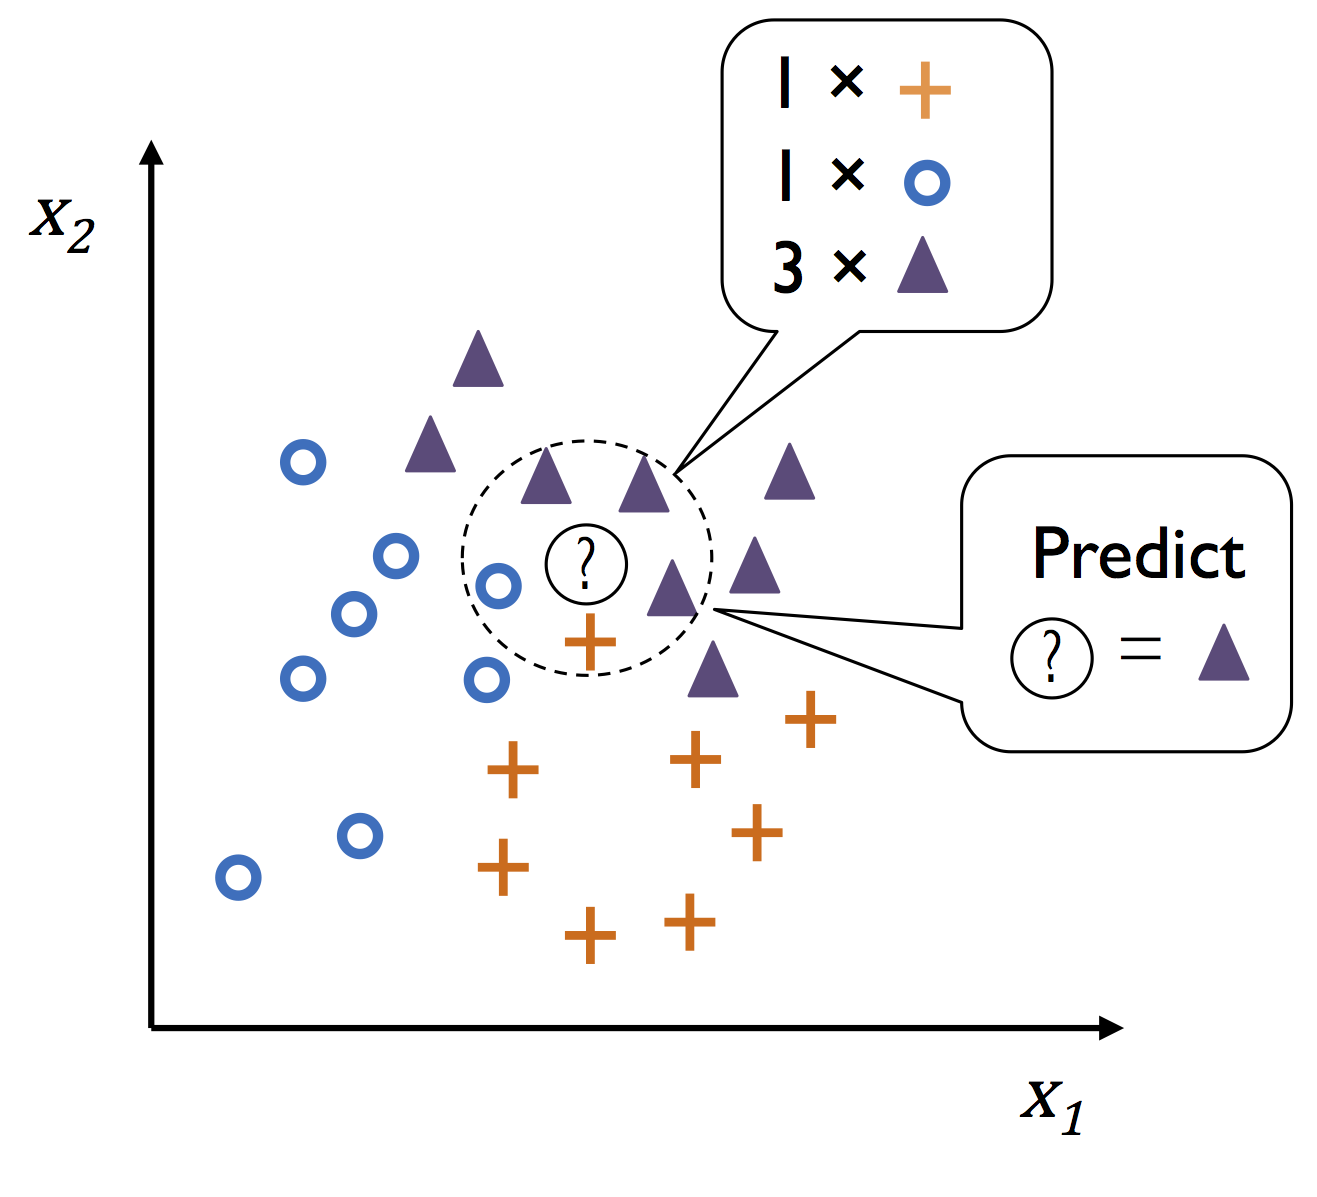

In [37]:
Image(filename='images/03_23.png', width=400) 

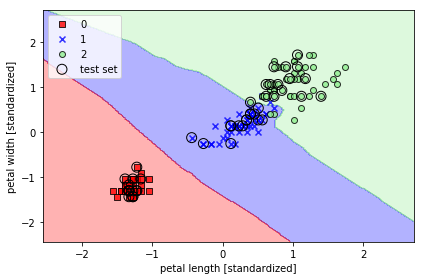

In [38]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('images/knn.png', dpi=300)
plt.show()

<br>

## Multilabel classsification

In [41]:
y_train_0=(y_train==0)
y_train_2=(y_train==2)
y_multilabel=np.c_[y_train_0, y_train_2]

In [45]:
knn.fit(X_train_std, y_multilabel)
knn.predict(X_test_std[0:10])

array([[False,  True],
       [ True, False],
       [ True, False],
       [False,  True],
       [False, False],
       [False, False],
       [False,  True],
       [False, False],
       [False,  True],
       [ True, False]], dtype=bool)

## Multioutput classification

In [47]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')

In [48]:
mnist_X,mnist_y = mnist['data'], mnist['target']

In [49]:
mnist_X_train, mnist_X_test, mnist_y_train, mnist_y_test = mnist_X[:60000], mnist_X[60000:], mnist_y[:60000], mnist_y[60000:]

In [54]:
noise = np.random.randint(0,100, (len(mnist_X_train), 784))
X_train_mod = mnist_X_train + noise
noise = np.random.randint(0,100, (len(mnist_X_test), 784))
X_test_mod = mnist_X_test + noise
y_train_mod = mnist_X_train
y_test_mod = mnist_X_test

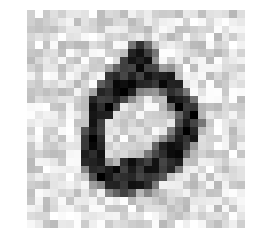

In [65]:
plot_digit(X_test_mod[0])
plt.show()

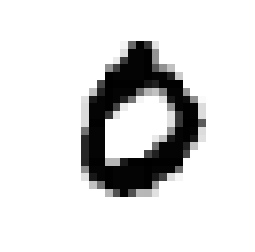

In [66]:
plot_digit(y_test_mod[0])
plt.show()

In [55]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

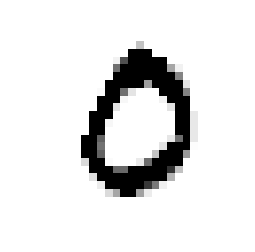

In [60]:
knn.fit(X_train_mod, y_train_mod)
clean_digit = knn.predict([X_test_mod[0]])
plot_digit(clean_digit)